# Итоговая работа практическая работа. А/В Тесты.
## Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [109]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from statsmodels.stats import proportion

In [110]:
import matplotlib.pyplot as plt

In [111]:
df = pd.read_csv('cookie_cats.csv', )

## Проведем первичный анализ:

In [112]:
df.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [114]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


Проверим количество пользователей которые не сыграли ни одного раунда, брать в оценку таких пользователей считаю не верным, в связи с тем , что изменения не могли повлиять на их решения.

In [115]:
df.query('sum_gamerounds < 1').shape[0] / df.shape[0] * 100

4.42847797403231

Таких пользователей менее 5 процентов, удалим их из датасета.

In [116]:
new_df = df.query('sum_gamerounds > 0')

Построим boxplot для того чтобы визуализировать возможные выбросы.

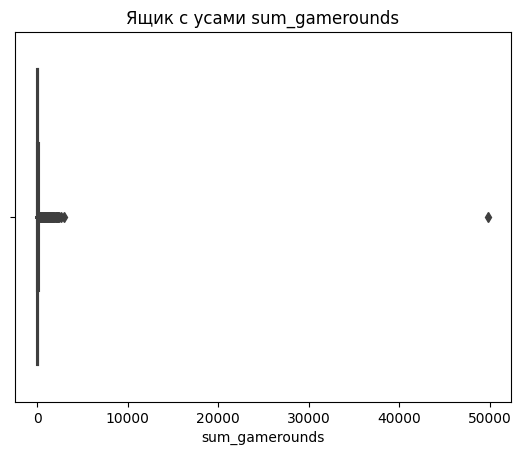

In [117]:
sns.boxplot(x=new_df['sum_gamerounds'])
plt.xlabel('sum_gamerounds')
plt.title('Ящик с усами sum_gamerounds');

Сильно выделяется значение в районе 50000, уберем его.

In [118]:
new_df = df.query('sum_gamerounds < 10000')

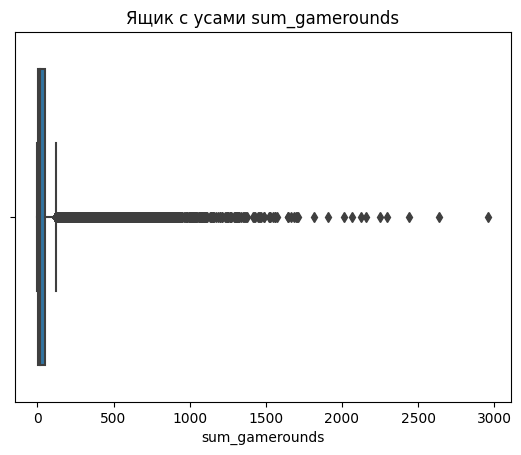

In [119]:
sns.boxplot(x=new_df['sum_gamerounds'])
plt.xlabel('sum_gamerounds')
plt.title('Ящик с усами sum_gamerounds');

In [120]:
new_df.query('sum_gamerounds > 100').shape

(12384, 5)

График стал более читабелен, но тем не менее, есть большое количество потенциальных выбросов,  
необходимо уточнение по данным строкам.  
Пока что продолжим работу не изменяя данные.

Визуально проверим распределение данных по "sum_gamerounds".  
Построим гистограмму и QQ-график, для наглядности проигнорируем потенциальные выбросы.

In [121]:
for_hist = new_df.query('sum_gamerounds < 101')

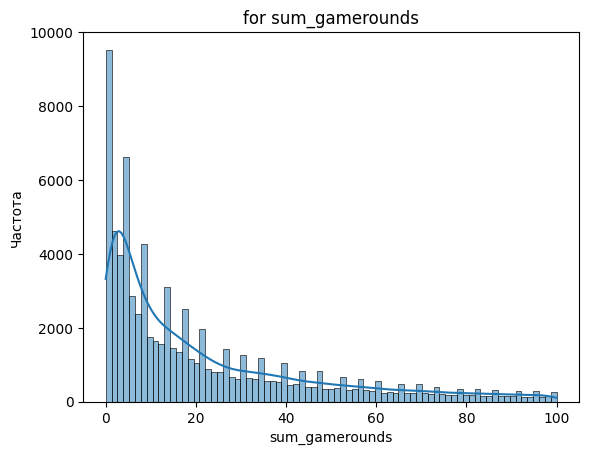

In [122]:
sns.histplot(for_hist['sum_gamerounds'], kde=True)
plt.xlabel('sum_gamerounds')
plt.ylabel('Частота')
plt.title('for sum_gamerounds');

Text(0.5, 1.0, 'QQ-график sum_gamerounds')

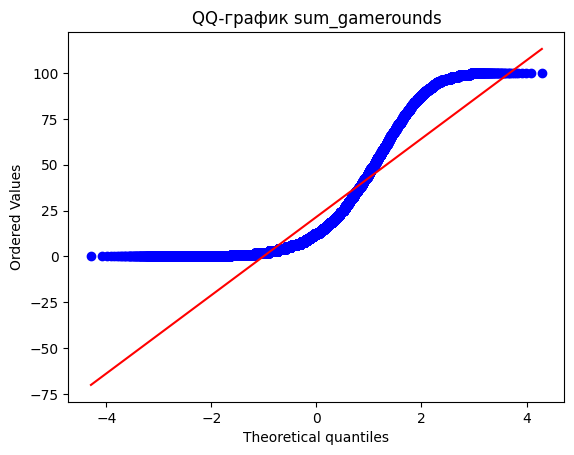

In [123]:
stats.probplot(for_hist['sum_gamerounds'], plot=plt)
plt.title('QQ-график sum_gamerounds')

Наблюдается отсутствие нормального распределения.  
Воспользуемся **Критерием Мана-Уитни** для выявления разницы между группами.

In [124]:
stats.mannwhitneyu(new_df[df['version'] == 'gate_30']['sum_gamerounds'], new_df[df['version'] == 'gate_40']['sum_gamerounds'])[1]


C:\Users\79996\AppData\Local\Temp\ipykernel_3828\342481629.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stats.mannwhitneyu(new_df[df['version'] == 'gate_30']['sum_gamerounds'], new_df[df['version'] == 'gate_40']['sum_gamerounds'])[1]


0.05089155279145376

Мы наблюдаем то, что p-value больше alpha, в связи с этим мы принимаем нулевую гипотезу, и говорим что различий между двумя группами нет. 

________________________________________________________________________________

## Рассмотрим как изменения повлияли на удержание:

Выполним **хи-квадрат тест** для проверки влияния изменений для _retention_1_ и _retention_7_:

In [126]:
n1, n2 = new_df.version.value_counts()
k1_1, k2_1 = new_df.query('retention_1 == 1').version.value_counts()
k1_7, k2_7 = new_df.query('retention_7 == 1').version.value_counts()

In [127]:
proportion.proportions_chisquare(np.array([k1_1, k2_1]), np.array([n1, n2]))[1]

0.07392076034183398

In [128]:
proportion.proportions_chisquare(np.array([k1_7, k2_7]), np.array([n1, n2]))[1]

0.5209290510671231

Мы наблюдаем то, что __p-value__ больше __alpha__, в связи с этим мы принимаем нулевую гипотезу, и говорим что различий между двумя группами нет.  
Это утверждение верно для *retention_1*, и для *retention_7*.

## Вывод:
Изменения ни оказали влияния на удержание пользователей, не на их вовлеченность.   
Рекомендуем не вводить изменения для всех пользователей и откатить версию у тестовой группы.   
Дополнительно рекомендуем пересмотреть алгоритм сплитования чтобы исключить не активных пользователей.  
Так же, уделить внимание аномально большим значениям в поле sum_gamerounds,  
убедится что они не являются выбросами, а если это не так то принять соответствующие меры.  